In [1]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.base import avgFromFull, layerFromFull
from networkAlignmentAnalysis.models.models import MLP
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import datasets

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [2]:
preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            transforms.Lambda(torch.flatten), # convert to vectors
        ])
trainloader, testloader = datasets.downloadMNIST(batchSize=2048, preprocess=preprocess)

In [6]:
net = MLP()
net.to(DEVICE)
    
# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
# optimizer = torch.optim.Adadelta(net.parameters())
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Preallocate summary variables  
iterations = 20
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

init_weights = net.get_alignment_weights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    print('iteration: ', epoch)
    
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in tqdm(enumerate(trainloader)):
        cidx = epoch*len(trainloader) + idx
        
        images, label = batch
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images, store_hidden=True)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

        # Measure Integration
        alignFull.append(net.measure_alignment(images, precomputed=True, method='alignment'))
        
        # Measure Change in Weights
        deltaWeights.append(net.compare_weights(init_weights))

    # Print statistics for each epoch
    print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))


Added a linear layer to the network
Added a linear layer to the network
Added a linear layer to the network
Added a linear layer to the network
iteration:  0


30it [00:04,  7.36it/s]


Loss in epoch   0: 2.232, Accuracy: 19.08%.
iteration:  1


30it [00:04,  7.39it/s]


Loss in epoch   1: 1.875, Accuracy: 37.83%.
iteration:  2


30it [00:04,  7.35it/s]


Loss in epoch   2: 1.412, Accuracy: 49.84%.
iteration:  3


30it [00:04,  7.28it/s]


Loss in epoch   3: 1.053, Accuracy: 65.95%.
iteration:  4


30it [00:04,  7.49it/s]


Loss in epoch   4: 0.996, Accuracy: 67.60%.
iteration:  5


30it [00:03,  7.51it/s]


Loss in epoch   5: 0.847, Accuracy: 72.37%.
iteration:  6


30it [00:04,  7.23it/s]


Loss in epoch   6: 0.743, Accuracy: 78.62%.
iteration:  7


30it [00:04,  7.40it/s]


Loss in epoch   7: 0.744, Accuracy: 75.66%.
iteration:  8


30it [00:04,  7.35it/s]


Loss in epoch   8: 0.690, Accuracy: 77.47%.
iteration:  9


30it [00:04,  7.48it/s]


Loss in epoch   9: 0.579, Accuracy: 84.21%.
iteration:  10


30it [00:04,  7.49it/s]


Loss in epoch  10: 0.581, Accuracy: 83.55%.
iteration:  11


30it [00:03,  7.55it/s]


Loss in epoch  11: 0.574, Accuracy: 84.05%.
iteration:  12


30it [00:03,  7.54it/s]


Loss in epoch  12: 0.575, Accuracy: 83.72%.
iteration:  13


30it [00:03,  7.52it/s]


Loss in epoch  13: 0.505, Accuracy: 83.88%.
iteration:  14


30it [00:03,  7.60it/s]


Loss in epoch  14: 0.455, Accuracy: 86.51%.
iteration:  15


30it [00:04,  7.45it/s]


Loss in epoch  15: 0.426, Accuracy: 86.84%.
iteration:  16


30it [00:04,  7.47it/s]


Loss in epoch  16: 0.435, Accuracy: 87.34%.
iteration:  17


30it [00:03,  7.69it/s]


Loss in epoch  17: 0.454, Accuracy: 88.49%.
iteration:  18


30it [00:03,  7.51it/s]


Loss in epoch  18: 0.496, Accuracy: 87.66%.
iteration:  19


30it [00:04,  7.44it/s]

Loss in epoch  19: 0.434, Accuracy: 87.17%.


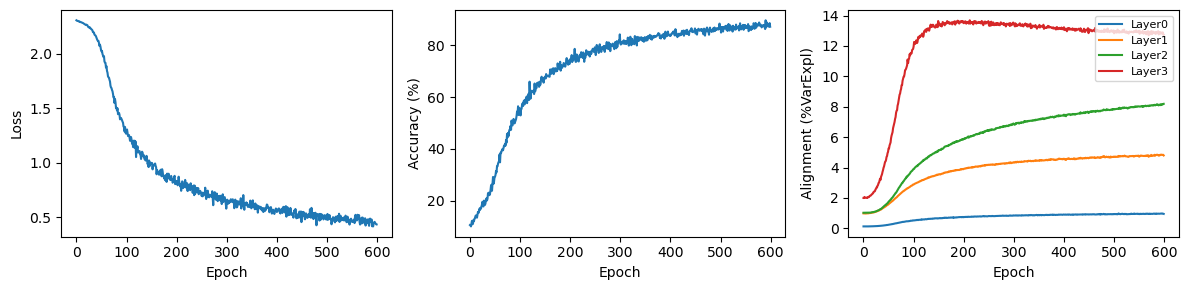

In [7]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = trackLoss.shape[0]
alignMean = avgFromFull(alignFull)

# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(trackLoss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(trackAccuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment (%VarExpl)')
ax[2].legend(fontsize=8, loc='upper right')

plt.tight_layout()

In [8]:
# TODO
# 1. Write more models (rewrite convolutional and AlexNet into AlignmentModels)
# 2. Make datasets a class
# 3. Make training a nice method
# 4. Rewrite existing analysis pipelines